In [54]:
import numpy as np
import os
from sklearn.cluster import KMeans
from matplotlib import pyplot as plt
import scipy
import math

from scipy.spatial.distance import cdist
from scipy.stats import multivariate_normal

from scipy.io import wavfile
from sklearn.cluster import KMeans

# Spectrogram calculation function

In [55]:
def spectrogram(X,sr):
   
    #25ms window is equal to 25ms*16khz=400 sample window
    window=25*10**(-3)*sr
    
    #10 ms hop is equal to 10ms*16khz=160 sample hop
    hop=10*10**(-3)*sr
    
    FFT=64
    
    # calculate number of frames
    frames = 1 + np.int32(np.floor((len(X) - window) / float(hop)))
    Y = np.zeros((frames, FFT), np.complex64)
    
    #finding FFT features for each frame
    for i in range(frames):
        start=int(i*hop)
        end=int(start+window)
        z = X[start: end] * np.hamming(window)
        Y[i] = np.fft.fft(z, n=FFT)
    
            
    # obtain log of the absolute values of the features and selected only 128 out of 256
    Y= np.log(np.abs(Y[:, :32]))
  
    return Y

# Load data function

In [56]:
def load_data(path):

    input_list = os.listdir(path)
    frames=[]

    for file_name in input_list:
#         print(file_name)
        file_path = path + file_name
        samp_rate, data= wavfile.read(file_path)
        spec=spectrogram(data,samp_rate)
        frames.extend(spec)
        
    frames = np.array(frames)
    return frames  
   

In [57]:
def infinity_replacement(X,N):
    for i in range(N):
        for j in range(D):
            if math.isinf(X[i][j]):
                X[i][j] = np.mean(X[i-1])
                
    return X

# Loading train data

In [58]:
music_path= 'speechMusicData/speech_music_classification/train/music/'
speech_path='speechMusicData/speech_music_classification/train/speech/'

music_data=load_data(music_path)
speech_data=load_data(speech_path)
# print(music_data)
(N,D)=speech_data.shape
music_data=infinity_replacement(music_data,N)
speech_Data=infinity_replacement(speech_data,N)

print(music_data.shape)
print(speech_data.shape)

(119920, 32)
(119920, 32)


# K-means algorithm

In [59]:
def KMEANS(X,k):

    row,col=X.shape
   
    #initializing centers randomly
    np.random.seed(4160659)
    centers = X[np.random.choice(row, k, replace=False)]
    
    closest = np.zeros(row).astype(int)
    count=20
    while True:
        old_closest = closest.copy()
        # calculating distance of each point from the center
        distances = cdist(X, centers)
        #calculating closest center for each data point
        closest = np.argmin(distances, axis=1)
    
        #updating centers
        for i in range(k):
            centers[i, :] = X[closest == i].mean(axis=0)
        #if conversion occurs    
        count-=1
        if all(closest == old_closest  ):
                break
    
    return centers, closest 
    
    return 0

# Full covariance matrix function

In [60]:
def full_sigma(Z,mean,weight,sigma):
    
#     sigma = np.zeros((K,D,D))
    for k in range(K):
        for i in range(N):
            diff = (X[i]-mean[k]).reshape(1,D)
            sigma[k] += Z[i,k] * np.dot(diff.T, diff)
        
        sigma[k] /= weight[k]
        

# Diagonal covariance matrix function

In [61]:
def diag_sigma(Z,mean,weight,sigma):
    
#     sigma = np.zeros((K,D,D))
    for k in range(K):
        sigmaTemp=np.zeros((1,D))
        for i in range(N):
        
            diff = ((X[i]-mean[k])**2).reshape(1,D)
            
            sigmaTemp += Z[i,k] * diff
            #print(sigmaTemp)
        
        sigmaTemp /= weight[k]
        #sigmaTemp+=1e-6
       
        sigma[k]=np.diag(sigmaTemp.reshape(D,))
        #new_covs[i].flat[::data.shape[1] + 1] += 1e-6
       

# Multivariant gaussian probability function


In [62]:
def Prob_Gaussian(x,mean,sigma):
    
    x=x.reshape(D,1)
    
    mean=mean.reshape(D,1)
 
    sig_inv = np.linalg.inv(sigma)
    
    temp=-1 * 0.5 * np.matmul(np.matmul((x-mean).T,sig_inv),(x-mean))
    
    exponent = np.exp(temp)
    
    prob = exponent/np.sqrt(np.power(2*np.pi,D)*np.linalg.det(sigma))
      
#     prob=multivariate_normal.pdf(x, mean=mean, cov=sigma)
    
    return prob

# E step

In [63]:
def E_step1(X,mean,sigma,alpha):
    
    N, D = X.shape
    
    print("N =",N)
    
    Z = np.zeros((N, K))
    
    Y = np.zeros((K, N))
    
    for j in range(K):
        Y[j] = multivariate_normal.pdf(X, mean=mean[j].flatten(), cov=sigma[j])

        
    logsum = 0

    for i in range(N):
        D = 0
        for j in range(K):
            D += (alpha[j] * Y[j][i])
        for j in range(K):
            numerator = (alpha[j] * Y[j][i])
            Z[i][j] = numerator / D
        
        logsum += math.log(D)
    
    return (logsum, Z)
            

# M step

In [64]:
def M_step1(X,Z,diag):
    
    NK = np.zeros(K)
    
    newAlpha = np.zeros(K)
    
    newMean = np.zeros((K, 1, 32))

    newSigma = np.zeros((K, 32, 32))

    for i in range(N):

        for j in range(K):
            NK[j] += Z[i][j]
            newMean[j] += X[i:i+1,:] * Z[i][j]
            

    for j in range(K):
        newMean[j] /= NK[j]
        

    for j in range(K):
        newAlpha[j] = NK[j] / N
        
    weight = np.sum(Z, axis=0)     
     
    if(diag):
         diag_sigma(Z,newMean,weight,newSigma)
    else:
        full_sigma(Z,newMean,weight,newSigma)
        

    return (newAlpha, newMean, newSigma)
    

# Log Likelihood function

In [65]:
def likelihood(X, alpha, mean, sigma):
    LL = 0  
    sum = 0
    N, t = X.shape
  
    for n in range(N): 
        sum=0
        for k in range(K):
            sum += alpha[k] * Prob_Gaussian(X[n], mean[k], sigma[k])
            
        LL += np.log(sum)
        sum = 0
    
    return LL

In [66]:
iterations = 8

def GMM1(X, mean, sigma, alpha, diag):
    
    Z = np.zeros((N, K))

    LL_values = []

    P = np.zeros((K, N))

    for itr in range(iterations):
        
        print("Running")
        
        # calculating multivariate gaussian prob for each data point
        for j in range(K):
            P[j] = multivariate_normal.pdf(X, mean=mean[j].flatten(), cov=sigma[j])
            
        # calculating loglikelihood and our wight matrix Z
        logSum = 0
      
        for n in range(N):
            denominator = 0
            for k in range(K):
                denominator += (alpha[k] * P[k][n])
            
            for k in range(K):
                numerator = (alpha[k] * P[k][n])
                Z[n][k] = numerator / denominator
        
            logSum += math.log(denominator)

        LL_values.append(logSum)
        
        alpha,mean,sigma = M_step1(X,Z,diag)

    logArray = np.array(LL_values)
    return logArray, mean, sigma, alpha


# K-mean Initialization function

In [67]:
def KMEAN_INIT(X,K,diag):
    N, D = X.shape
    mean, closest = KMEANS(X,K)

    sigma = np.zeros((K,D,D))
    alpha = np.zeros((K))
    Z= np.zeros((N,K))

    for i in range(N):    
        Z[i][closest[i]] = 1

    weight=np.sum(Z,axis=0)
    alpha=weight/N
    
    if(diag==False):
         full_sigma(Z,mean,weight,sigma)
    else:
         diag_sigma(Z,mean,weight,sigma)
        
        
    return (mean, alpha,sigma,Z)


# function to plot log-likelihood

In [68]:
def plot_likelihood(LL_values, name):
    plt.plot([i for i in range(1,iterations + 1)],LL_values)
    plt.xlabel('Iterations')
    plt.ylabel('Likelihood Value')
    plt.title('Plot of Likelihood for {}'.format(name))
    plt.show()

# K = 2 and 5 mixture with diagonal covariance

# Music class

# Step1: Initialization with K-Mean

In [69]:
diag = True
K=2
X=music_data

N, D = music_data.shape
(mean,alpha,sigma,Z)= KMEAN_INIT(X,K, diag)

print(sigma.shape)

(2, 32, 32)


# Step2: EM algorithm Iteration

In [70]:
LL_music, meanM, sigmaM, alphaM = GMM1(X, mean, sigma, alpha, diag)
# print(LL_music)


Running
Running
Running
Running
Running
Running
Running
Running


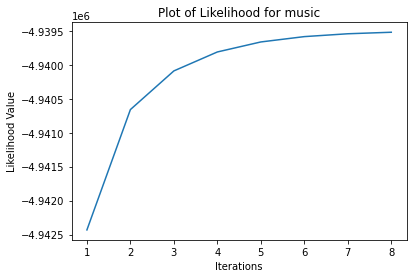

In [71]:
# Plot the log likelihood for Music model
plot_likelihood(LL_music,"music")

# Speech class

# Step1: Initialization with K-Mean

In [72]:
X=speech_data

N,D = X.shape
(mean,alpha,sigma,Z)= KMEAN_INIT(X,K, diag)
# print(Z)

# Step2: EM algorithm Iteration

Running
Running
Running
Running
Running
Running
Running
Running
[-5388008.22240498 -5386913.8271326  -5386806.08246231 -5386790.39161048
 -5386786.11990657 -5386784.46349518 -5386783.75866961 -5386783.45336977]


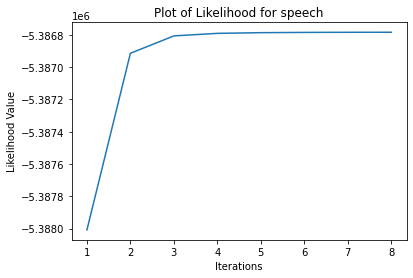

In [73]:
LL_speech, meanS, sigmaS, alphaS = GMM1(X, mean, sigma, alpha, diag)
print(LL_speech)
plot_likelihood(LL_speech,"speech")

# Test_Data Error Checking

In [74]:
def get_likelihood(X, mean, alpha, sigma):

    N, D = X.shape
    K = 2
    # here, D = 32, N = 2998
#     print(N, K)
    
    P1 = np.zeros((K, N))

    
    for j in range(K):
        P1[j] = multivariate_normal.pdf(X, mean=meanM[j].flatten(), cov=sigmaM[j])
    
#     print("here")
    
    P2 = np.zeros((K, N))

    for j in range(K):
        P2[j] = multivariate_normal.pdf(X, mean=meanS[j].flatten(), cov=sigmaS[j])

    
    for j in range(N):
        music = 0
        speech = 0
        probM = 0
        probS = 0
        for k in range(K):
            probM += (alphaM[k] * P1[k][j])
            probS += (alphaS[k] * P2[k][j])
            
        if(probM > probS):
            music += 1
        else:
            speech += 1
    if(music>speech):
        return 1
    else:
        return 0
    

# Predicting whether a file belong to music or speech:
### Based on posterior probability of the data point inside a file - If more data points have higher posterior probability in music, then the file belong to music class otherwise to speech class

In [75]:
print(meanS.shape)
test_path='speechMusicData/speech_music_classification/test/'
input_list = os.listdir(test_path)
path=test_path
pred_labels = []
count=0
correct=0
for file_name in input_list:

    file_path = path + file_name
    samp_rate ,data= wavfile.read(file_path)
    spec=spectrogram(data,samp_rate)
    pred = get_likelihood(spec,meanS,alphaS,sigmaS)

    if count<24 and pred==1:
        correct+=1
    if count>=24 and pred==0:
        correct+=1
    count+=1  


(2, 1, 32)


In [76]:
accuracy = (correct) / 48
print("Accuracy is =",accuracy)

error = 1 - accuracy
print("Error is =",error * 100,"%")
     

Accuracy is = 0.5625
Error is = 43.75 %


# Observations

# 1. For K = 2 with diagonal covariance matrix, error rate is 43 %

# 2. For K = 2 with full covariance matrix, error rate is 35%

# 3. For K = 5 with daig cov matrix, error rate is 23%

# 4. We can see that with increase in number of GMMs, the better approximation we get for the data distribution. Consequently, less error rate. 

# 5. By using the diagonal cov matrix, the computational cost decreases but at the cost of accuracy.